# TIMESERIES - PREPARATION

This notebook handles the preprocessed MovieLens dataset, explores the timeserie characteristics and prepares the dataset to be used for forecasting.

In [4]:
#Necessary imports

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import joblib

#Preparation of a dictionary to gather the movie name from the code assgines

df_movies = pd.read_csv("data/master_data_with_movie_info.zip")
df_movies_title = df_movies[["movieId", "title"]]
movie_names_dict = {num: name for num, name  in df_movies_title.values}
joblib.dump(movie_names_dict, "movie_dict.pkl")

['movie_dict.pkl']

## Explore the dataset

In [6]:
df = pd.read_csv("data/master_data.zip")

df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s')

df["Year"] = df["timestamp"].dt.year
df["Month"] = df["timestamp"].dt.month

In [7]:
#Number of movies
total_num = df["movieId"].nunique()
print(f"Total number of movies: {total_num}")

#Number of ratings
total_num_ratings = len(df)
print(f"Total number of ratings: {total_num_ratings}")

#Highest number of ratings per movie
highest_rating_number = df.groupby("movieId").count()["userId"].max()
print(f"Highest number of ratings per movie: {highest_rating_number}")

#Lowest number of ratings per movie
lowest_rating_number = df.groupby("movieId").count()["userId"].min()
print(f"Lowest number of ratings per movie: {lowest_rating_number}")

#Lowest number of ratings per movie
mean_rating_number = df.groupby("movieId").count()["userId"].mean()
print(f"Average number of ratings per movie: {np.round(mean_rating_number)}")

Total number of movies: 4489
Total number of ratings: 11155339
Highest number of ratings per movie: 21333
Lowest number of ratings per movie: 223
Average number of ratings per movie: 2485.0


<Axes: xlabel='rating_counts', ylabel='Count'>

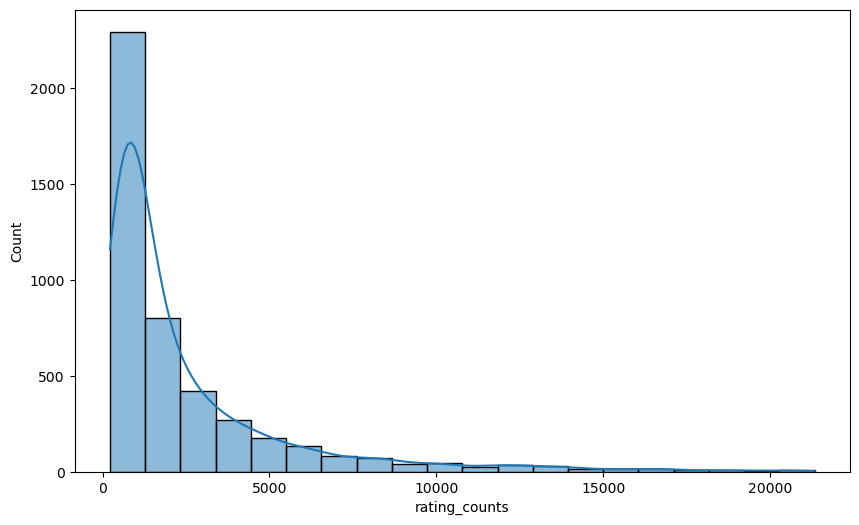

In [8]:
#Distribution of rating counts

movie_rating_counts = pd.DataFrame(df.groupby("movieId").count()["rating"])
movie_rating_counts.columns = ["rating_counts"]

plt.figure(figsize=(10,6), dpi=100)
sns.histplot(data=movie_rating_counts, x='rating_counts',bins=20, kde=True)

#plt.savefig('Distribution of counts.png',bbox_inches='tight', dpi=100)


    Year  rating_counts
0   1996         174738
1   1997         188084
2   1998         152727
3   1999         693456
4   2000        1215469
5   2001         748773
6   2002         560788
7   2003         692304
8   2004         811713
9   2005        1229666
10  2006         790279
11  2007         693170
12  2008         707850
13  2009         534361
14  2010         491665
15  2011         394598
16  2012         385185
17  2013         289171
18  2014         262611
19  2015         138731


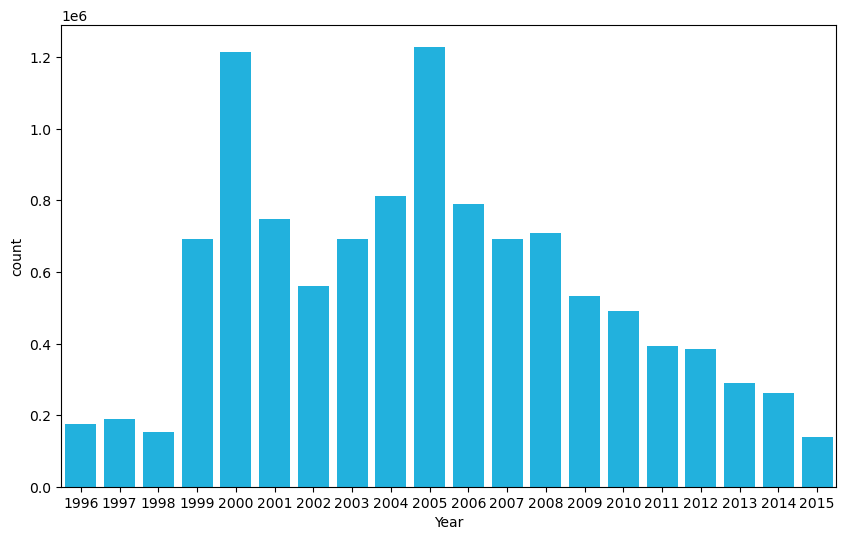

In [9]:
#Distribution of rating counts per year

year_rating_counts = pd.DataFrame(df.groupby("Year").count()["rating"]).reset_index()
year_rating_counts.columns = ["Year", "rating_counts"]

plt.figure(figsize=(10,6), dpi=100)
sns.countplot(data=df, x='Year', color="#03c2fc")

#plt.savefig('Distribution of counts per year.png',bbox_inches='tight', dpi=100)

print(year_rating_counts)

## Time-series Inspection

As this can be done on single time-series, it is not feasible to do it for every movie. For demonstation purposes, it will be done on movie with the highest number of rating, movie with lowest number of ratings and the movie that has the number of ratings closest to the average number of ratings.

In [10]:
#Movie with highest number of ratings
id_highest_rating_number = df.groupby("movieId").count()["userId"].idxmax()
max_movie = movie_names_dict.get(id_highest_rating_number)
print(f"Movie with highest number of ratings: {max_movie}, internal_id: {id_highest_rating_number}")

#Movie with lowest number of ratings
id_lowest_rating_number = df.groupby("movieId").count()["userId"].idxmin()
min_movie = movie_names_dict.get(id_lowest_rating_number)
print(f"Movie with lowest number of ratings: {min_movie}, internal_id: {id_lowest_rating_number}")

#Movie with average number of ratings
mean_rating_number = df.groupby("movieId").count()["userId"].mean()
mean_movie_id = (df.groupby("movieId").count()["userId"] - mean_rating_number).abs().idxmin()+1
mean_movie = movie_names_dict.get(mean_movie_id)
print(f"Movie with the average number of ratings: {mean_movie}, internal_id: {mean_movie_id}")

Movie with highest number of ratings: Forrest Gump (1994), internal_id: 281
Movie with lowest number of ratings: Last Dance (1996), internal_id: 527
Movie with the average number of ratings: Risky Business (1983), internal_id: 1870


In [18]:
ts_max_movie = df.loc[df[df["movieId"]==id_highest_rating_number].index, :]
ts_max_movie = ts_max_movie.set_index("timestamp")
ts_max_movie = ts_max_movie.groupby(pd.Grouper(freq='M'))["userId"].count()
ts_max_movie.name = "Rating Counts"

ts_mean_movie = df.loc[df[df["movieId"]==mean_movie_id].index, :]
ts_mean_movie = ts_mean_movie.set_index("timestamp")
ts_mean_movie = ts_mean_movie.groupby(pd.Grouper(freq='M'))["userId"].count()
ts_mean_movie.name = "Rating Counts"

ts_min_movie = df.loc[df[df["movieId"]==id_lowest_rating_number].index, :]
ts_min_movie = ts_min_movie.set_index("timestamp")
ts_min_movie = ts_min_movie.groupby(pd.Grouper(freq='M'))["userId"].count()
ts_min_movie.name = "Rating Counts"

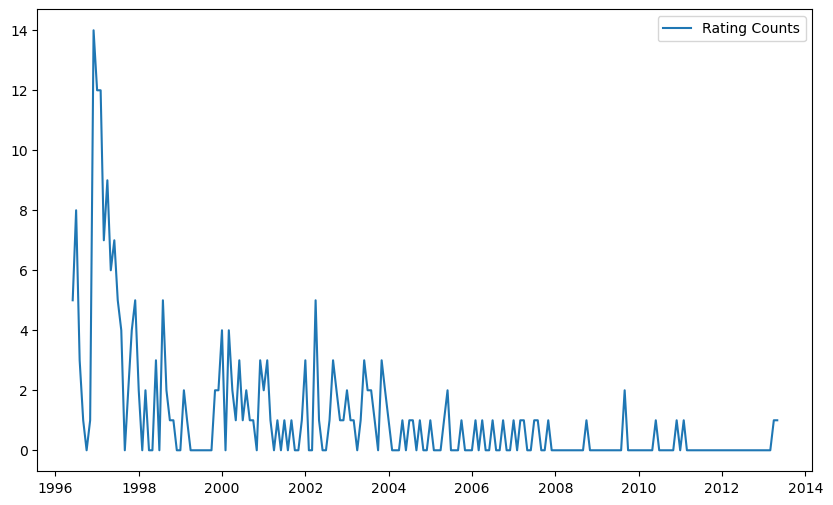

In [104]:
plt.figure(figsize=(10,6), dpi=100)
plt.plot(ts_min_movie, label="Rating Counts")
plt.legend()
plt.savefig('ts_min_movie.png',bbox_inches='tight', dpi=100)


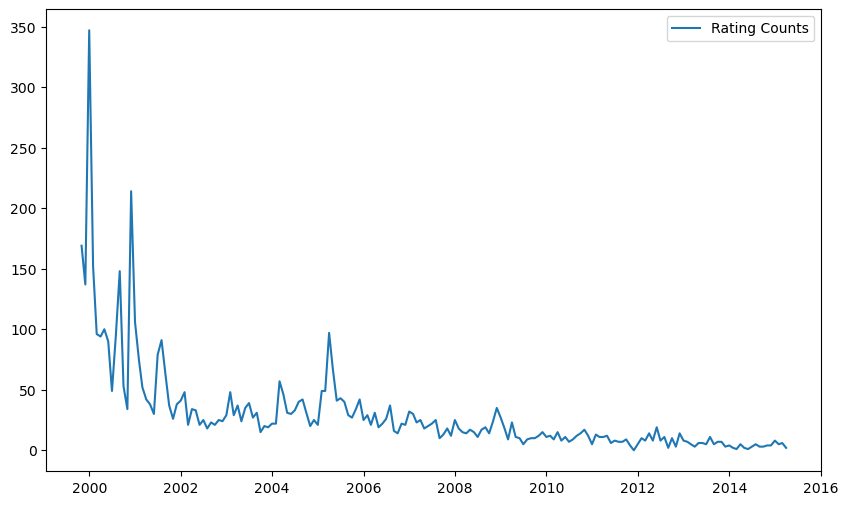

In [105]:
plt.figure(figsize=(10,6), dpi=100)
plt.plot(ts_mean_movie, label="Rating Counts")
plt.legend()
plt.savefig('ts_mean_movie.png',bbox_inches='tight', dpi=100)


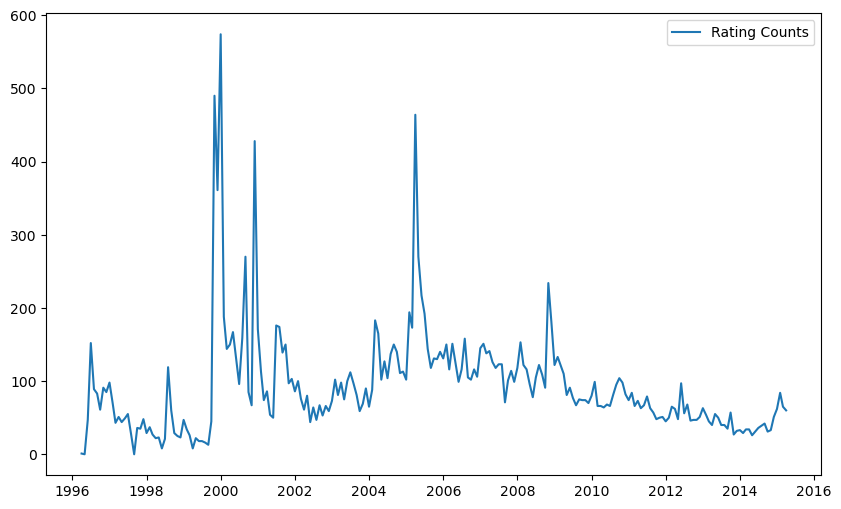

In [19]:
plt.figure(figsize=(10,6), dpi=100)
plt.plot(ts_max_movie, label="Rating Counts")
plt.legend()
plt.savefig('ts_max_movie.png',bbox_inches='tight', dpi=100)


## Seasonal Decomposition

As this can be done on single time-series, it is not feasible to do it for every movie. For demonstation purposes, it will be done on movie with the highest number of rating, movie with lowest number of ratings and the movie that has the number of ratings closest to the average number of ratings.

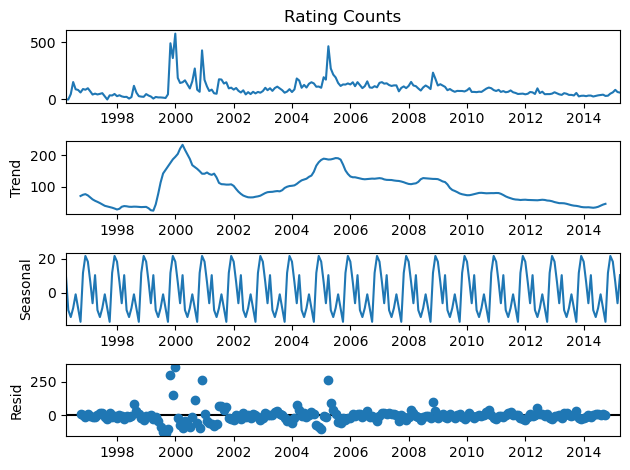

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_max = seasonal_decompose(x=ts_max_movie, model="additive")
decomposition_max.plot();
plt.savefig('seasonal_max.png',bbox_inches='tight', dpi=100)

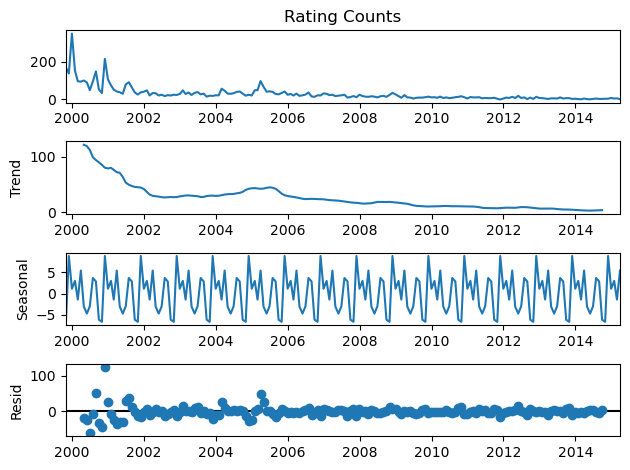

In [117]:
decomposition_mean = seasonal_decompose(x=ts_mean_movie, model="additive")
decomposition_mean.plot();
plt.savefig('seasonal_mean.png',bbox_inches='tight', dpi=100)

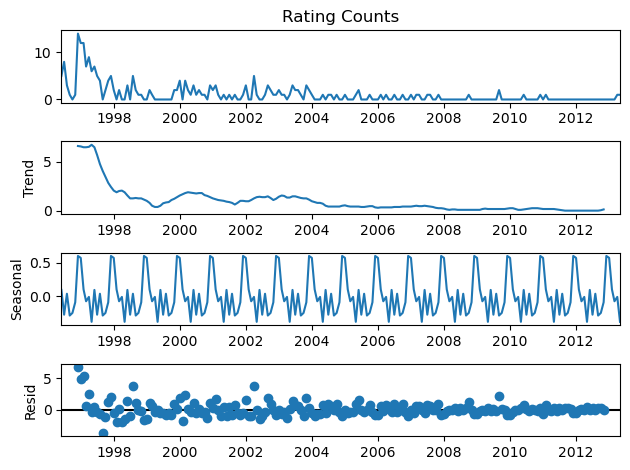

In [14]:
decomposition_min = seasonal_decompose(x=ts_min_movie, model="additive")
decomposition_min.plot();
plt.savefig('seasonal_min.png',bbox_inches='tight', dpi=100)

## Seasonality

As this can be done on single time-series, it is not feasible to do it for every movie. For demonstation purposes, it will be done on movie with the highest number of rating, movie with lowest number of ratings and the movie that has the number of ratings closest to the average number of ratings.

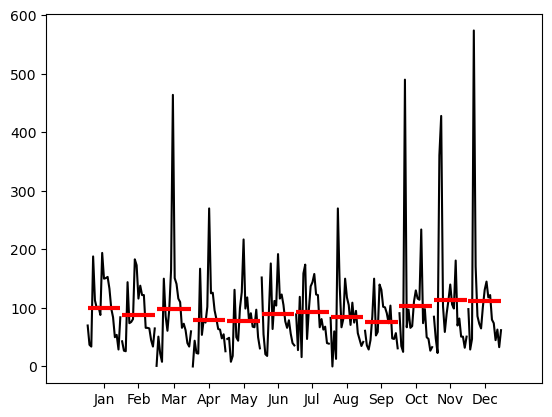

In [29]:
from statsmodels.graphics.tsaplots import month_plot

month_plot(ts_max_movie.resample(rule="MS").mean());
plt.savefig('seasonality_max.png',bbox_inches='tight', dpi=100)

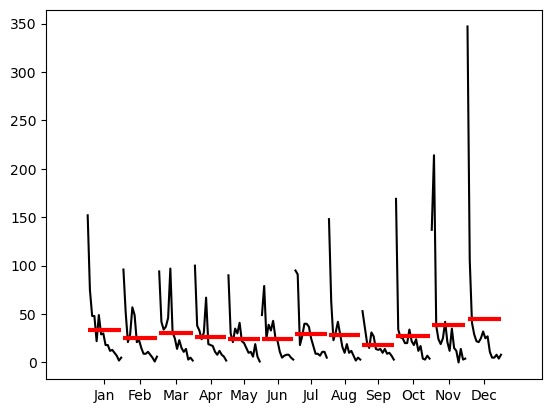

In [30]:
month_plot(ts_mean_movie.resample(rule="MS").mean());
plt.savefig('seasonality_mean.png',bbox_inches='tight', dpi=100)

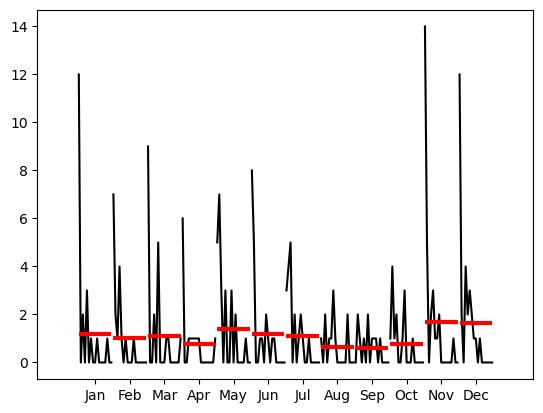

In [31]:
month_plot(ts_min_movie.resample(rule="MS").mean());
plt.savefig('seasonality_min.png',bbox_inches='tight', dpi=100)